# Imports

In [72]:
from pymoo.core.problem import ElementwiseProblem
from pymoo.termination import get_termination
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter
from pymoo.decomposition.asf import ASF
from pymoo.mcdm.pseudo_weights import PseudoWeights
from pymoo.indicators.hv import Hypervolume
from pymoo.util.running_metric import RunningMetricAnimation
from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting
from pymoo.indicators.igd import IGD
import matplotlib.pyplot as plt
import numpy as np

# Inizializzazione e risoluzione del problema

In [73]:
class Constrained3Obj(ElementwiseProblem):
    
    def __init__(self):
        super().__init__(
            n_var=6,
            n_obj=3,
            n_constr=5,
            xl=np.zeros(6),
            xu=np.ones(6)
            )

    def _evaluate(self, x, out, *args, **kwargs):
        # Funzioni obiettivo (3) -> F rappresentato in 3D.
        f1 = x[0] + 2.0 * x[1] + 0.15 * np.sin(6.0 * np.pi * x[2])
        f2 = (1.0 - x[0])**2 + x[3] + 0.2 * np.cos(4.0 * np.pi * x[4])
        f3 = x[1] * x[2] + (1.0 - x[3]) * x[5] + 0.1 * x[4]
        
        out["F"] = np.array([f1, f2, f3])
        
        # Vincoli (7) -> avere constraints sufficientemente complessi da ottenere
        # valori non-triviali delle metriche che usano cv_min, cv_avg.
        # 1-2) Somma stretta: x0 + x1 ∈ [0.6, 0.65]
        s = x[0] + x[1]
        g1 = 0.6 - s
        g2 = s - 0.65
        
        # 3) Prodotto x2 * x3 >= 0.8
        g3 = 0.8 - (x[2] * x[3])
        
        # 4) Threshold combinato su x5 e x4
        g4 = 0.75 - (0.5 * x[5] + 0.4 * x[4])
        
        # 5) x5 >= 0.7
        g5 = 0.7 - x[5]
        
        out["G"] = np.array([g1, g2, g3, g4, g5])

In [74]:
problem = Constrained3Obj()
algorithm = NSGA2()
termination = get_termination("n_gen", 200)

res = minimize(problem, algorithm, termination, seed=1, save_history=True, verbose=True)

X = res.G
F = res.F

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      100 |      1 |  0.2597783871 |  1.5253892301 |             - |             -
     2 |      200 |      1 |  0.2276090262 |  0.9025499923 |             - |             -
     3 |      300 |      1 |  0.0485647140 |  0.5864689028 |             - |             -
     4 |      400 |      1 |  0.0485647140 |  0.3876982869 |             - |             -
     5 |      500 |      1 |  0.0426431555 |  0.2498343582 |             - |             -
     6 |      600 |      1 |  0.000000E+00 |  0.1524837154 |             - |             -
     7 |      700 |      3 |  0.000000E+00 |  0.0660402404 |  1.0000000000 |         ideal
     8 |      800 |      4 |  0.000000E+00 |  0.0319159865 |  0.1834312789 |         ideal
     9 |      900 |      5 |  0.000000E+00 |  0.0115441341 |  0.1850756437 |         ideal
    10 |     1000 |      8 |  0.000000E+00 |  0.0020678738 |  0.0344253550 |         ideal

# Visualizzazione

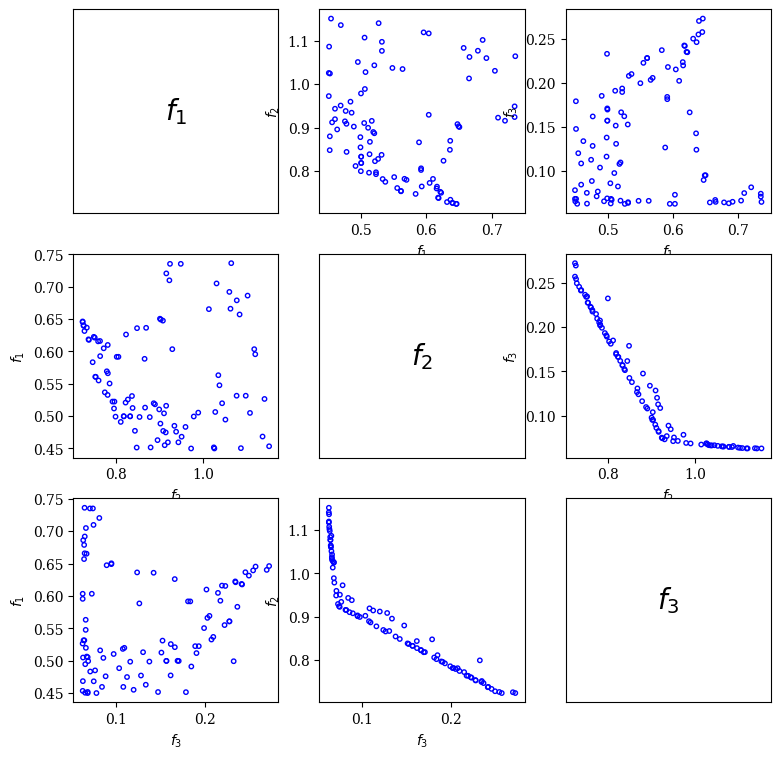

In [75]:
scatter_matrix = Scatter(plot_3d=False)
scatter_matrix.figsize = (9, 9)
scatter_matrix.add(F, facecolors="none", edgecolors="blue", s=10)
scatter_matrix.show()

Ideal Point (Approx): [0.45001731 0.72413382 0.06268352]
Nadir Point (Approx): [0.73633932 1.15114119 0.27269794]


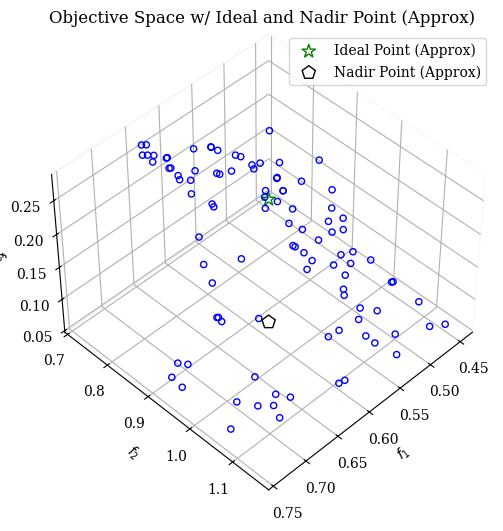

In [76]:
approx_ideal = F.min(axis=0)
approx_nadir = F.max(axis=0)

print("Ideal Point (Approx):", approx_ideal)
print("Nadir Point (Approx):", approx_nadir)

obj_space_scatter = Scatter()
obj_space_scatter.add(res.pop.get("F"), facecolors="none", edgecolors="blue")
obj_space_scatter.add(approx_ideal, facecolors="none", edgecolors="green", marker="*", s=100, label="Ideal Point (Approx)")
obj_space_scatter.add(approx_nadir, facecolors="none", edgecolors="black", marker="p", s=100, label="Nadir Point (Approx)")
obj_space_scatter.title = "Objective Space w/ Ideal and Nadir Point (Approx)"
obj_space_scatter.legend = "True"
obj_space_scatter.show()

F shape: (100, 3)
CV mean: 0.0


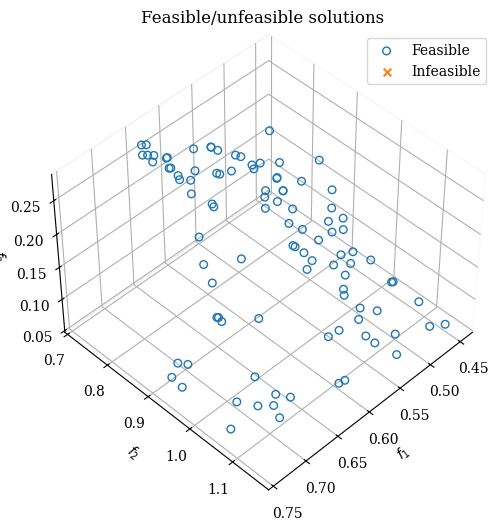

In [77]:
pop = res.pop

F_POP = res.pop.get("F")
CV_POP = res.pop.get("CV")

print("F shape:", F.shape)
print("CV mean:", np.mean(CV_POP))

is_feasible = (CV_POP <= 1e-6).flatten()

feasible_unfeasible_scatter = Scatter()
feasible_unfeasible_scatter.add(F[is_feasible], s=30, facecolor="none", label="Feasible")
feasible_unfeasible_scatter.add(F[~is_feasible], s=30, marker="x", label="Infeasible")
feasible_unfeasible_scatter.title = "Feasible/unfeasible solutions"
feasible_unfeasible_scatter.legend = "True"
feasible_unfeasible_scatter.show()


In [78]:
F = (F - approx_ideal) / (approx_nadir - approx_ideal)

Best solution regarding ASF: Point 
i = 59
F = [0.22055644 0.33487337 0.32410998]


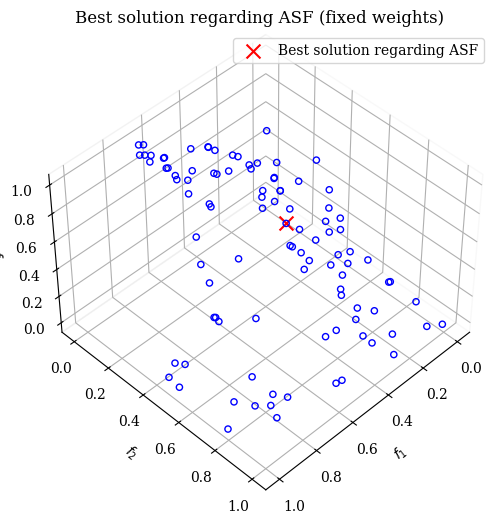

In [79]:
set_weights = np.array([0.4, 0.3, 0.3])

decomp = ASF()
i = decomp.do(F, 1 / set_weights).argmin()

print("Best solution regarding ASF: Point \ni = %s\nF = %s" % (i, F[i]))

set_weights_scatter = Scatter()
set_weights_scatter.add(F, facecolors="none", edgecolors="blue")
set_weights_scatter.add(F[i], facecolors="red", marker="x", s=100, label="Best solution regarding ASF")
set_weights_scatter.title = "Best solution regarding ASF (fixed weights)"
set_weights_scatter.legend = "True"
set_weights_scatter.show()

Best solution regarding pseudo weights: Point 
i = 16
F = [0.16991244 0.30528437 0.35797134]


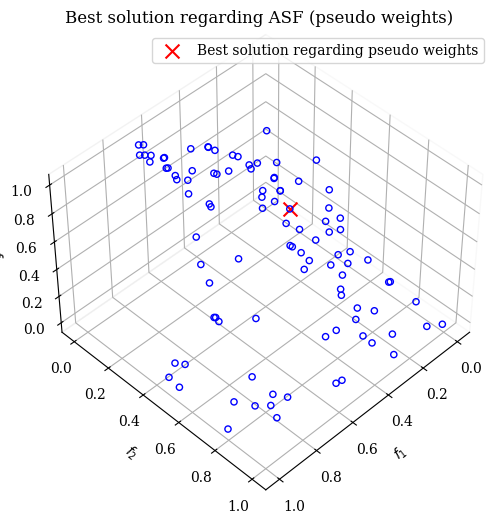

In [80]:
i = PseudoWeights(set_weights).do(F)

print("Best solution regarding pseudo weights: Point \ni = %s\nF = %s" % (i, F[i]))

pseudo_weights_scatter = Scatter()
pseudo_weights_scatter.add(F, facecolors="none", edgecolors="blue")
pseudo_weights_scatter.add(F[i], facecolors="red", marker="x", s=100, label="Best solution regarding pseudo weights")
pseudo_weights_scatter.title = "Best solution regarding ASF (pseudo weights)"
pseudo_weights_scatter.legend = "True"
pseudo_weights_scatter.show()

# Valutazione delle performance

In [81]:
n_evals = []
hist_F = []
hist_cv = []
hist_cv_avg = []

for algo in res.history:
    n_evals.append(algo.evaluator.n_eval)
    hist_cv.append(algo.opt.get("CV").min())
    hist_cv_avg.append(algo.pop.get("CV").mean())
    feas = np.where(algo.opt.get("feasible"))[0]
    hist_F.append(algo.opt.get("F")[feas])

Whole population feasible in Generation 10 after 1100 evaluations.


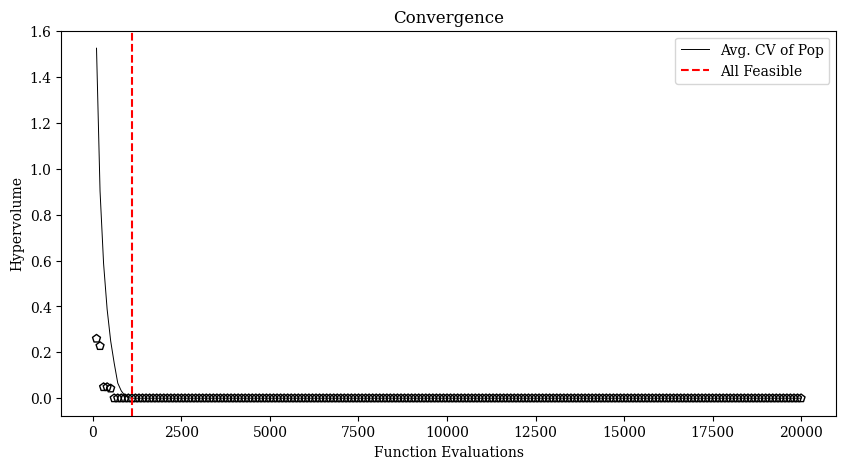

In [89]:

k = np.where(np.array(hist_cv_avg) <= 0.0)[0].min()
print(f"Whole population feasible in Generation {k} after {n_evals[k]} evaluations.")

plt.figure(figsize=(10, 5))
plt.plot(n_evals, hist_cv_avg,  color='black', lw=0.7, label="Avg. CV of Pop")
plt.scatter(n_evals, hist_cv,  facecolor="none", edgecolor='black', marker="p")
plt.axvline(n_evals[k], color="red", label="All Feasible", linestyle="--")
plt.title("Convergence")
plt.xlabel("Function Evaluations")
plt.ylabel("Hypervolume")
plt.legend()
plt.show()

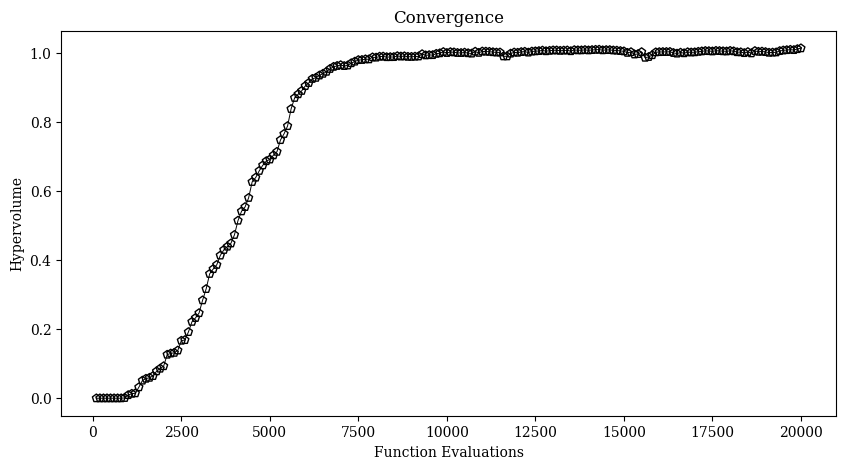

In [88]:
metric = Hypervolume(
    ref_point= np.array([1.1, 1.1, 1.1]),
    norm_ref_point=False,
    zero_to_one=True,
    ideal=approx_ideal,
    nadir=approx_nadir
    )

hv = [metric.do(_F) for _F in hist_F]

plt.figure(figsize=(10, 5))
plt.plot(n_evals, hv,  color='black', lw=0.7, label="Avg. CV of Pop")
plt.scatter(n_evals, hv,  facecolor="none", edgecolor='black', marker="p")
plt.title("Convergence")
plt.xlabel("Function Evaluations")
plt.ylabel("Hypervolume")
plt.show()

/home/cuguzzoni/Documenti/Progetto_tesi/Pratica_PyMOO/pymoo-env/lib64/python3.13/site-packages/pymoo/termination/ftol.py:14: RuntimeWarning: invalid value encountered in divide
  return np.max(np.abs((a - b) / norm))
/home/cuguzzoni/Documenti/Progetto_tesi/Pratica_PyMOO/pymoo-env/lib64/python3.13/site-packages/pymoo/termination/ftol.py:14: RuntimeWarning: divide by zero encountered in divide
  return np.max(np.abs((a - b) / norm))


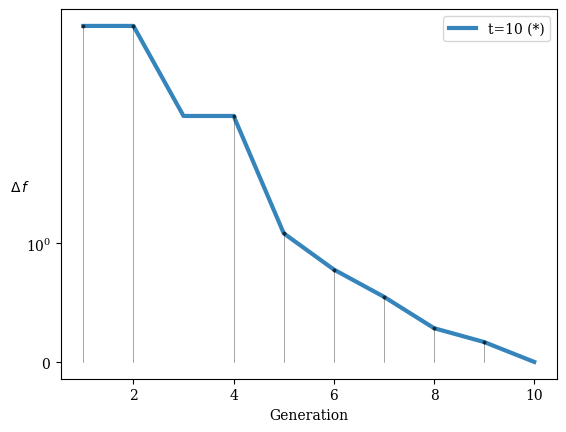

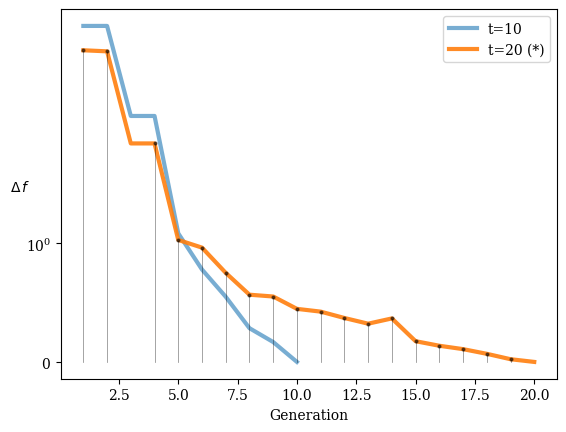

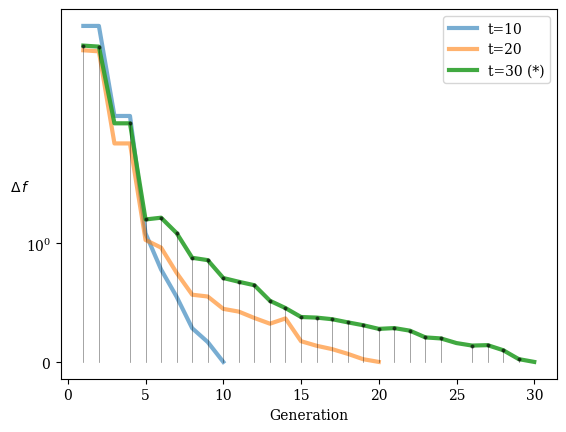

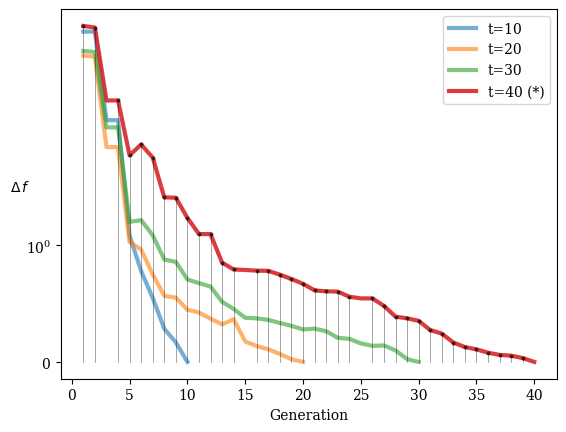

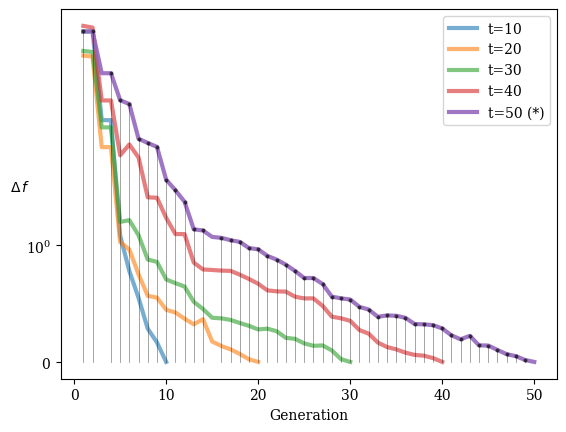

In [84]:
running_rirst_generations = RunningMetricAnimation(
    delta_gen=10,
    n_plots=5,
    key_press=False,
    do_show=True
    )

for algorithm in res.history[:50]:
    running_rirst_generations.update(algorithm)

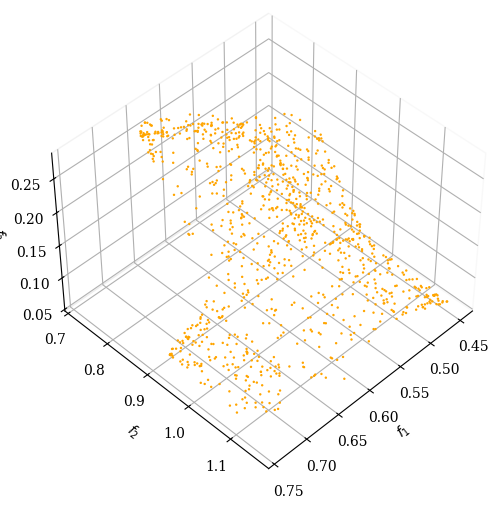

In [85]:
N_RUNS = 20
POP_SIZE = 100

all_F = []

for r in range (N_RUNS):
    res = minimize(
        problem,
        NSGA2(POP_SIZE),
        get_termination("n_gen", 200),
        seed=r,
        verbose=False
    )
    
    all_F.append(res.pop.get("F"))

all_F = np.array(all_F)
all_F = all_F.reshape(N_RUNS * 100, problem.n_obj)

nds = NonDominatedSorting()

front_idx = nds.do(all_F, only_non_dominated_front=True)

approx_pf = all_F[front_idx]

scatter_pf = Scatter()
scatter_pf.add(approx_pf, facecolors="orange", edgecolors="none", s=3)
scatter_pf.show()

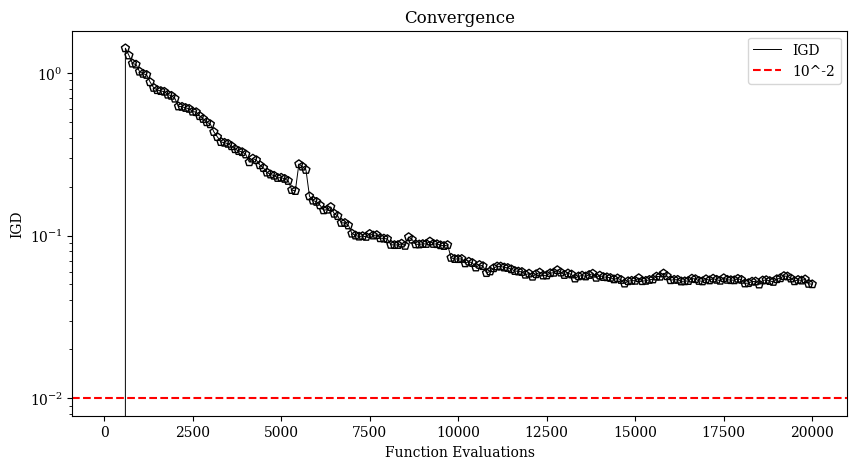

In [86]:
metric = IGD(approx_pf, zero_to_one=True)

igd = [metric.do(_F) for _F in hist_F]

plt.figure(figsize=(10, 5))
plt.plot(n_evals, igd,  color='black', lw=0.7, label="IGD")
plt.scatter(n_evals, igd,  facecolor="none", edgecolor='black', marker="p")
plt.axhline(10**-2, color="red", label="10^-2", linestyle="--")
plt.title("Convergence")
plt.xlabel("Function Evaluations")
plt.ylabel("IGD")
plt.yscale("log")
plt.legend()
plt.show()